In [36]:
from dataclasses import dataclass
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm
import gymnasium as gym

from workspace.utils.training_config import TrainingConfig

In [37]:
def make_env(num_episodes):
    env = gym.make("Blackjack-v1", sab=True)
    return gym.wrappers.RecordEpisodeStatistics(env, buffer_length=num_episodes)

In [38]:
def train_agent(env, agent, cfg: TrainingConfig):
    for _ in tqdm(range(cfg.n_episodes)):
        obs, _ = env.reset()
        done = False
        while not done:
            action = agent.get_action(obs)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            agent.update(obs, action, reward, terminated, next_obs)
            obs = next_obs
            done = terminated or truncated
        agent.decay_epsilon()

In [39]:
def moving_average(x, window, mode = "same"):
    return np.convolve(x, np.ones(window), mode=mode) / window

In [40]:
def plot_training(env, agent, rolling_length = 1000):
    fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
    axs[0].set_title("Episode rewards")
    rewards = np.array(env.return_queue).flatten()
    axs[0].plot(moving_average(rewards, rolling_length, mode="valid"))

    axs[1].set_title("Episode lengths")
    lengths = np.array(env.length_queue).flatten()
    axs[1].plot(moving_average(lengths, rolling_length, mode="same"))

    axs[2].set_title("Training Error")
    errs = np.array(agent.training_error)
    axs[2].plot(moving_average(errs, rolling_length, mode="same"))

    plt.tight_layout()
    plt.show()

In [41]:
def create_grids(agent, usable_ace = False):
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(np.arange(12, 22), np.arange(1, 11))

    value = np.apply_along_axis(
        lambda o: state_value[(int(o[0]), int(o[1]), usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )

    policy_grid = np.apply_along_axis(
        lambda o: policy[(int(o[0]), int(o[1]), usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )

    return (player_count, dealer_count, value), policy_grid

In [42]:
def create_plots(value_grid, policy_grid, title: str):
    player_count, dealer_count, value = value_grid
    fig = plt.figure(figsize=plt.figaspect(0.4))
    fig.suptitle(title, fontsize=16)

    ax1 = fig.add_subplot(1, 2, 1, projection="3d")
    ax1.plot_surface(player_count, dealer_count, value, rstride=1, cstride=1, cmap="viridis", edgecolor="none")
    ax1.set_title(f"State values: {title}")
    ax1.set_xlabel("Player sum")
    ax1.set_ylabel("Dealer showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    ax2 = fig.add_subplot(1, 2, 2)
    sns.heatmap(policy_grid, linewidth=0, annot=True, cmap="Accent_r", cbar=False, ax=ax2)
    ax2.set_title(f"Policy: {title}")
    ax2.set_xlabel("Player sum")
    ax2.set_ylabel("Dealer showing")
    ax2.set_xticklabels(range(12, 22))
    ax2.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)

    legend_elements = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick"),
    ]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.3, 1))
    return fig

In [43]:
cfg = TrainingConfig()
env = make_env(cfg.n_episodes)

In [44]:
from workspace.agents.time_diff import TDAgent
from workspace.agents.monte_carlo import MonteCarloAgent
from workspace.agents.monte_carlo_es import MonteCarloESAgent
from workspace.agents.dqn import DQNAgent

In [45]:
agents =[
    # TDAgent(action_n=env.action_space.n, cfg=cfg),
    # MonteCarloAgent(action_n=env.action_space.n, cfg=cfg),
    # MonteCarloESAgent(action_n=env.action_space.n, cfg=cfg),
    DQNAgent(action_n=env.action_space.n, cfg=cfg),
]

100%|██████████| 1000/1000 [00:05<00:00, 166.83it/s]


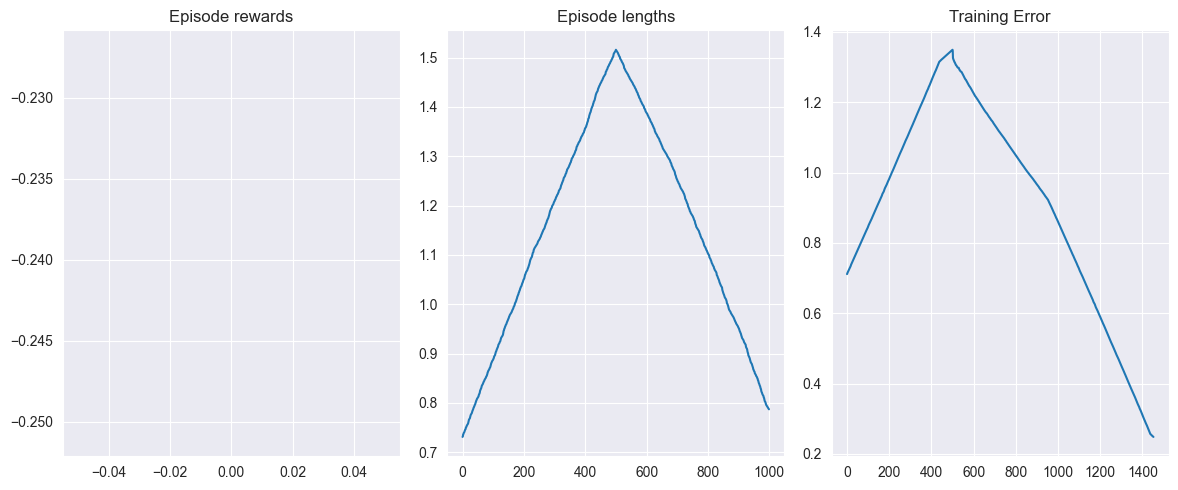

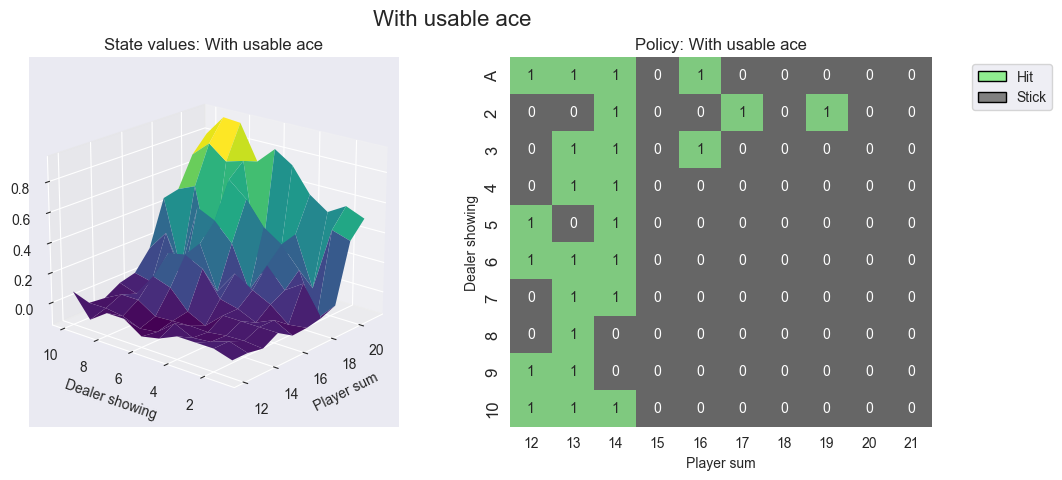

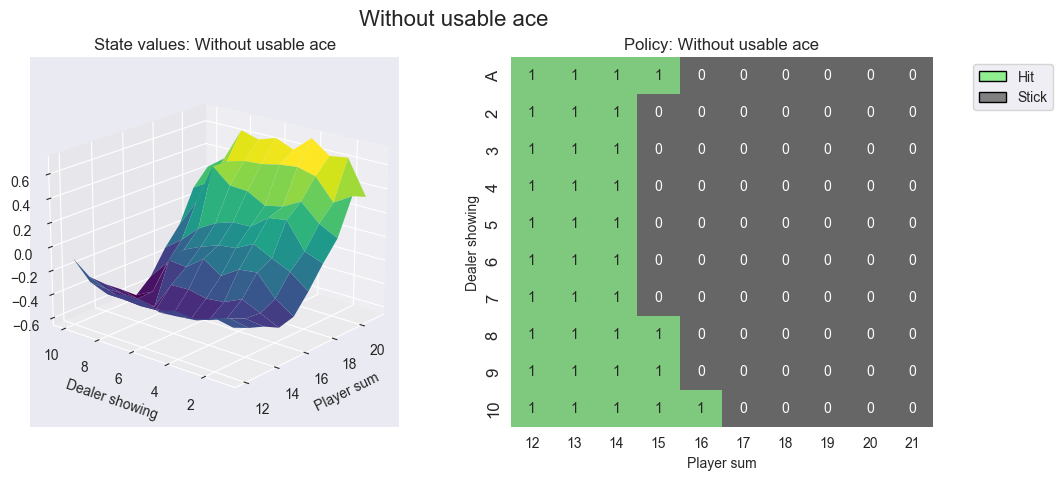

In [46]:
for agent in agents:
    train_agent(env, agent, cfg)

    plot_training(env, agent)

    v_g, p_g = create_grids(agent, usable_ace=True)
    create_plots(v_g, p_g, "With usable ace")
    plt.show()

    v_g, p_g = create_grids(agent, usable_ace=False)
    create_plots(v_g, p_g, "Without usable ace")
    plt.show()